# NN cascade for URZ

* Radek Hofman, Apr 2018
* changed 9/5/2018 before meeting with SA

* we limit RETIME=0 to make sure we train on correct parameters
* correct output nodes (see node1-6 in the C code)
* corrected NAB, TAB values in training set, chaged datatypes in ML_FEATURES_CONTEXTUAL
* weights with suffix NTC Nab, Tab Correct
* copy of URZ_R2_correct_NABTAB.ipynb
* With normalization of Features as in iwt_nnet.c : iwt_normalize() 
* we restruict ourselves to data up to 2017/01/01 00:00 for training and validation, we test on data after 2017
* we use weighted cost function to put more focus on associated phases than on noise

https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

## Datasets used

To obtain weights files in this notebook, two datasets have been used:


#### N-TPS training

* retime = 0 (weight file labeles as R0: 'URZ_R0_NTC3_NTPS.h5')
* number of noise phases 4times higher than the number of associated phases

    - regional S (1868, 25)
    - regional P (3378, 25)
    - teleseismic (7498, 25)

* associated total (12744, 25)

------------------------------------------
* noise (50976, 25) - 4 times more than associated

#### TPS classification

* retime <= 2s (weights files labeled as R2: 'URZ_R2_NTC_TPS.h5', 'URZ_R2_NTC_TP.h5')

    - regional S (5922, 25)
    - regional P (7318, 25)
    - teleseismic (21934, 25)

* associated total (29252, 25)

------------------------------------------
* noise (35174) - 4 times associated


# Problem statement

* Neural networks are used in StaPro for initial wave type determination (iwt) for 3C stations
* The purpose is to assign an initial wave type to each arrival
* The system comprises of a sequence of three binary classifiers: 
    - **Step 1:** the system tries to distinguish between noise (N) and a signal (P or S wave)
    - **Step 2:** if signal: is it P or S wave?
    - **Step 3:** if P: is it regional P or teleseismic P?
* Currently, all the NNs uses the same weights trained on data from **STKA** station
* We will attempt to re-train the network using data from different station for **Step 1**

The sequence of binary classifiers is illustrated on the following diagram from *Sereno and Gagan, 1993*:

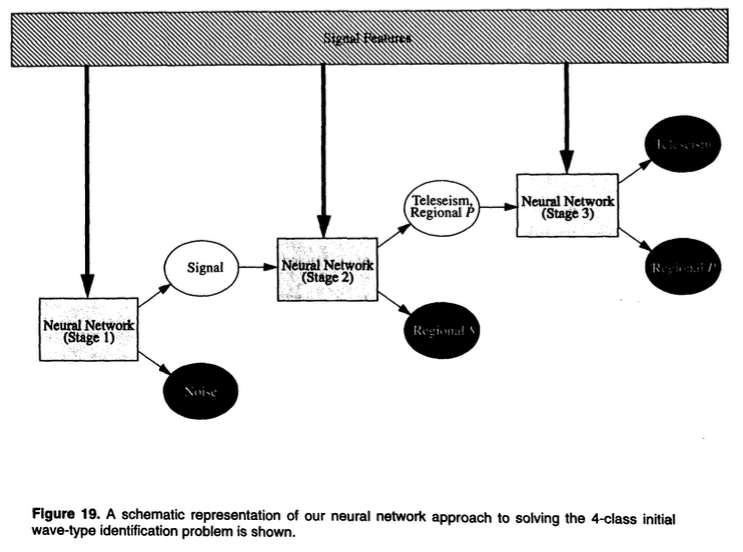

In [38]:
from IPython.display import Image
Image(filename=os.path.join('pics', 'StaPro_nn_cascade.png')) 

* Binary classifiers in each step are implemented as a neural network (multiplayer perceptron) with:
    - 15 inputs
    - one hidden layer with 6 units
    - 2 ouput (for each class one)
* NNs in all steps have the same topology and take the same inputs (features):
 1. **$period$**: Dominant period of the detected phase.
 2. **$rect$**: Signal rectilinearity
 3. **$plans$**: Signal planarity
 4. **$inang_1$**: Long-axis incidence angle
 5. **$inang_3$**: Short-axis incidence angle
 6. **$hmxmn$**: Ratio of the maximum to minimum horizontal amplitude:
 7. **$hvratp$**: Ratio of horizontal-to-vertical power: hvratp   snn see, where szzYsnn, and
 8. **$hvrat$**: Similar to hvratp, however measured at the time of the maximum three-
component amplitude.
 9. **$N_{after} - N_{before}$**: Difference between the number of arrivals before and after the
arrival in question within a fixed time window  60 seconds by default). The value of the number difference is scaled to a small range near  1 by dividing by 10.
 10. **$T_{after} - T_{before}$**: Mean-time di erence between the arrival in question and those arrivals before and after it within a fixed time window  60 seconds by default). The value of the mean time difference is scaled to a small range near  1 by dividing by 100.
 11. **$htov_1$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 0.25 Hz.
 12. **$htov_2$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 0.5 Hz.
 13. **$htov_3$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 1.0 Hz.
 14. **$htov_4$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 2.0 Hz.
 15. **$htov_5$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 4.0 Hz.
 
 All features are normalized, see the normalization cell in the Code.
 
 In the following diagram from *Sereno and Gagan (1993)* we see inputs - slowness was later removed:

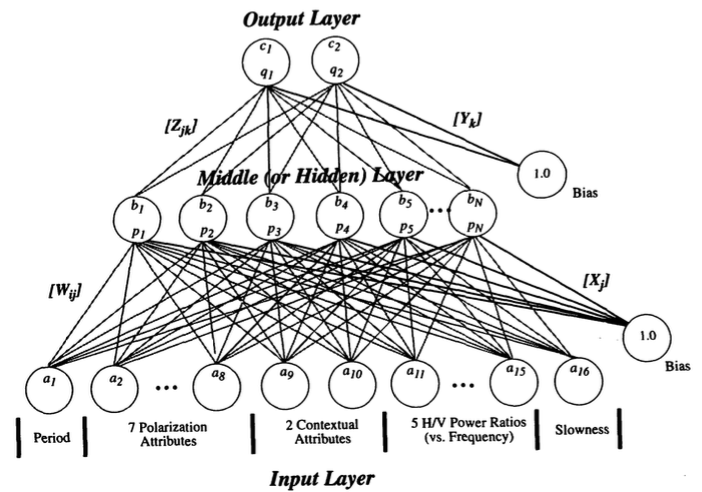

In [37]:
Image(filename=os.path.join('pics', 'nn_topology.png')) 

### References

* WANG, J., Adaptive training of neural networks for automatic seismic phase identification. Monitoring the Comprehensive Nuclear-Test-Bant Treaty: Data Processing and Infrasound (2002): 1021-1041.
* SERENO, T. and PATNAIK, G.  1993), Initial Wave-type Identification with Neural Networks and its
Contribution to Automated Processing in IMS Version 3.0, Technical Report, SAIC-93/1219.

# The code  (re-training and evaluation)

### Imports and axiliary functions and stuff

In [ ]:
%load_ext sql
%matplotlib inline

In [2]:
import os
import numpy
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open(os.path.join('/','home','hofman','.dbp.txt'), 'r') as f: password = f.read().strip()

In [4]:
query = "oracle://hofman:%s@mycelium.ctbto.org:1521/udb" % password
%sql $query

'Connected: hofman@udb'

In [5]:
% sql select count(*) from ml_features where sta='URZ'

0 rows affected.


COUNT(*)
399415


In [6]:
def plot(history, semilog=False):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(history['acc'], label='acc')
    ax.plot(history['val_acc'], label='val_acc')
    ax.set_ylabel('accuracy')
    if semilog:
        ax.set_yscale('log')
    plt.legend(loc='best')
    ax = fig.add_subplot(212)
    ax.plot(history['loss'], label='loss')
    ax.plot(history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    if semilog:
        ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

In [7]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

### What is the misclassification rate now for all arrivals in our DB?

* #(class_iphase != class_phase) / (#automatic which are not noise) 

In [147]:
#select from database required numbers
wrong_type = %sql select count(*) from ml_features where sta='URZ' and class_phase != class_iphase
total_number = %sql select count(*) from ml_features where sta='URZ' and phase!='N' and source!='M'

0 rows affected.
0 rows affected.


In [148]:
print('Percentage of misclassified initial wave types: %3.2f%%' % (wrong_type[0][0]/total_number[0][0]*100))

Percentage of misclassified initial wave types: 47.90%


### Dataframes per class phase type - RESTRICTION TO DATA BEFORE 2017 (1483228800)

In [149]:
#1483228800.00000 2017001  2017/01/01 00:00:00.00000 Jan Sun
query = """select * from ml_features where sta='URZ' and class_phase='regS' and time < 1483228800 and retime=0"""
df_S_all = pd.read_sql(query, con=connection)

In [150]:
df_S_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,25125356,URZ,1.125756e+09,Lg,regS,Sn,regS,0.0,A,0.333333,...,2.255508,2.322878,5.701331,-0.1,-0.330875,0.477908,0.308546,0.607835,2.215676,1.147653
1,25209949,URZ,1.126202e+09,Lg,regS,Sn,regS,0.0,A,0.166667,...,3.094621,5.262130,7.506219,-0.1,-0.119375,0.218329,1.932005,1.667993,4.337718,0.823034
2,25484937,URZ,1.127674e+09,Sx,regS,Sn,regS,0.0,A,0.333333,...,1.480349,1.709227,2.333341,0.3,0.117333,1.480681,2.671052,1.251162,2.918441,1.396981
3,25845443,URZ,1.129661e+09,Lg,regS,Sn,regS,0.0,A,0.166667,...,2.368714,3.631796,2.530992,-0.1,-0.238542,0.642853,3.236031,1.586349,2.377527,4.207438
4,25869005,URZ,1.129792e+09,Sx,regS,Sn,regS,0.0,A,0.166667,...,1.940398,1.944917,1.968780,0.0,-0.444125,3.153595,2.265633,0.730031,1.483259,3.839772


In [151]:
df_S_all.shape

(3870, 25)

In [152]:
query = """select * from ml_features where sta='URZ' and class_phase='regP' and time < 1483228800 and retime=0"""
df_P_all = pd.read_sql(query, con=connection)

In [153]:
df_P_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,14992929,URZ,1.070059e+09,Pn,regP,Pn,regP,0.0,A,0.333333,...,1.301846,1.112025,0.258914,0.6,0.288500,3.730434,0.738458,0.704325,0.247701,0.060989
1,15073977,URZ,1.070752e+09,Pg,regP,Pn,regP,0.0,A,0.166667,...,3.529159,0.085323,0.486815,0.3,0.189333,0.211185,0.225393,0.257161,0.413598,0.287086
2,15092556,URZ,1.070912e+09,Pg,regP,Pn,regP,0.0,A,0.166667,...,5.327707,0.110656,0.110656,0.3,-0.355750,0.955461,0.214671,0.042706,0.101636,0.043408
3,15130591,URZ,1.071154e+09,Pn,regP,Pn,regP,0.0,A,0.333333,...,2.314928,0.147518,0.143086,0.3,0.261667,2.204178,1.176155,0.430676,0.251630,0.083938
4,15138893,URZ,1.071213e+09,Pg,regP,Pn,regP,0.0,A,0.166667,...,3.196525,0.038832,0.199923,0.7,0.325107,0.381505,1.188019,0.411168,0.196104,0.108448


In [154]:
df_P_all.shape

(5765, 25)

In [155]:
query = """select * from ml_features where sta='URZ' and class_phase='tele' and time < 1483228800 and retime=0"""
df_T_all = pd.read_sql(query, con=connection)

In [156]:
df_T_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,28559193,URZ,1.143210e+09,P,tele,P,tele,0.0,A,0.333333,...,1.531207,0.084376,0.084376,0.2,0.098750,0.689514,0.333741,0.336678,0.119060,0.092935
1,28574895,URZ,1.143282e+09,P,tele,P,tele,0.0,A,0.333333,...,4.289076,0.045244,0.164040,0.2,0.135125,1.938697,0.469713,0.090036,0.197977,0.075261
2,28576710,URZ,1.143287e+09,P,tele,P,tele,0.0,A,0.333333,...,2.082907,0.071959,0.117020,0.1,0.113500,2.072605,2.122431,0.139297,0.116047,0.033339
3,28620356,URZ,1.143490e+09,P,tele,P,tele,0.0,A,0.333333,...,2.398478,0.046782,0.068094,0.2,0.181000,0.405509,0.324182,0.214481,0.101148,0.025588
4,28629600,URZ,1.143529e+09,P,tele,P,tele,0.0,A,0.333333,...,1.144497,0.070432,0.070432,0.1,0.057500,0.864729,0.934231,0.532630,0.089410,0.084397


In [157]:
df_T_all.shape

(14068, 25)

In [158]:
query = """select * from ml_features where sta='URZ' and class_phase='N' and time < 1483228800 and source!='Z'"""
df_N_all = pd.read_sql(query, con=connection)

In [159]:
df_N_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,13097443,URZ,1.055511e+09,N,N,None,N,0.0,A,0.166667,...,2.948945,9.600216,9.600216,0.0,0.00000,0.396880,1.145887,0.421142,0.406116,1.439137
1,13097727,URZ,1.055513e+09,N,N,None,N,0.0,A,0.444444,...,5.750848,9.726424,3.211865,0.0,0.00000,0.628241,0.617270,0.890586,2.788352,1.279634
2,13097728,URZ,1.055513e+09,N,N,None,N,0.0,A,1.000000,...,1.550819,0.163623,12.531935,0.1,0.50475,2.625565,0.419386,0.502452,1.093746,0.228218
3,13097729,URZ,1.055513e+09,N,N,None,N,0.0,A,0.333333,...,2.203439,0.328290,0.511023,-0.1,-0.50475,0.532591,1.455946,0.672186,0.730198,0.130826
4,13097946,URZ,1.055517e+09,N,N,None,N,0.0,A,1.000000,...,2.803004,0.827978,0.630203,0.0,0.00000,1.039954,0.420590,0.983108,0.450562,0.274970


In [160]:
df_N_all.shape

(283403, 25)

In [161]:
#save to csv
#df_ora.to_csv('URZ_pandas.csv')

In [162]:
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (3870, 25)
regP (5765, 25)
tele (14068, 25)
noise (283403, 25)


# Definition of input and output

In [163]:
# columns corresponding to input
x_indices = ['PER', 'RECT', 'PLANS', 'INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'NAB', 'TAB',  
             'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5']
print('features count:', len(x_indices))
# columns corresponding to output
y_indices = ['CLASS_PHASE']

metadata = ['ARID','STA','TIME','IPHASE','CLASS_IPHASE','PHASE','CLASS_PHASE','RETIME','SOURCE']

features count: 15


# Dataset for first phase of the cascade: N vs TPS

In [164]:
#counts of all classes
ns = df_S_all.shape[0]
np = df_P_all.shape[0]
nt = df_T_all.shape[0]
nn = df_N_all.shape[0]

#those from automatic
nsa = df_S_all[df_S_all['SOURCE'] != 'M'].shape[0]
npa = df_P_all[df_P_all['SOURCE'] != 'M'].shape[0]
nta = df_T_all[df_T_all['SOURCE'] != 'M'].shape[0]
nna = df_N_all[df_N_all['SOURCE'] != 'M'].shape[0]


#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
samp_count = min(nsa, npa, nta)

nmult = 1
#sample TPS dataset, random_state is a seed
ssS = df_S_all[df_S_all['SOURCE'] != 'M'].sample(nmult*nsa, random_state=11, replace=True)
ssP = df_P_all[df_P_all['SOURCE'] != 'M'].sample(nmult*npa, random_state=13, replace=True)
ssT = df_T_all[df_T_all['SOURCE'] != 'M'].sample(nmult*nta, random_state=17, replace=True)
TPS_data = pd.concat([ssS, ssP, ssT])

#sample noise phases
N_data = df_N_all[df_N_all['SOURCE'] != 'M'].sample(4*nmult*(nsa+npa+nta), random_state=23)

#lets shuffle dataset
TPS_data = TPS_data.sample(frac=1, random_state=51).reset_index(drop=True)
N_data = N_data.sample(frac=1, random_state=101).reset_index(drop=True)

print(ssS.shape, ssP.shape, ssT.shape)
print(TPS_data.shape)
print(N_data.shape)

(1868, 25) (3378, 25) (7498, 25)
(12744, 25)
(50976, 25)


### Normalization of data

* normalization according to iwt_nnet.c : iwt_normalize()


In [165]:
# check on positivity of all features which are going to be log10-ed:)
# check TPS data
print('TPS')
print(TPS_data['HVRAT'][TPS_data['HVRAT']<=0])
print(TPS_data['HVRATP'][TPS_data['HVRATP']<=0])
print(TPS_data['HMXMN'][TPS_data['HMXMN']<=0])
print(TPS_data['HTOV1'][TPS_data['HTOV1']<=0])
print(TPS_data['HTOV2'][TPS_data['HTOV2']<=0])
print(TPS_data['HTOV3'][TPS_data['HTOV3']<=0])
print(TPS_data['HTOV4'][TPS_data['HTOV4']<=0])
print(TPS_data['HTOV5'][TPS_data['HTOV5']<=0])
# check NOISE data
print('NOISE')
print(N_data['HVRAT'][N_data['HVRAT']<=0])
print(N_data['HVRATP'][N_data['HVRATP']<=0])
print(N_data['HMXMN'][N_data['HMXMN']<=0])
print(N_data['HTOV1'][N_data['HTOV1']<=0])
print(N_data['HTOV2'][N_data['HTOV2']<=0])
print(N_data['HTOV3'][N_data['HTOV3']<=0])
print(N_data['HTOV4'][N_data['HTOV4']<=0])
print(N_data['HTOV5'][N_data['HTOV5']<=0])

TPS
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)
NOISE
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)


In [166]:
# normalize TPS
TPS_data_norm = TPS_data.copy(deep=True)
TPS_data_norm['INANG1'] /= 90.
TPS_data_norm['INANG3'] /= 90.
TPS_data_norm['HMXMN'] = numpy.log10(TPS_data['HMXMN'])
TPS_data_norm['HVRATP'] = numpy.log10(TPS_data['HVRATP'])
TPS_data_norm['HVRAT'] = numpy.log10(TPS_data['HVRAT'])
TPS_data_norm['HTOV1'] = numpy.log10(TPS_data['HTOV1'])
TPS_data_norm['HTOV2'] = numpy.log10(TPS_data['HTOV2'])
TPS_data_norm['HTOV3'] = numpy.log10(TPS_data['HTOV3'])
TPS_data_norm['HTOV4'] = numpy.log10(TPS_data['HTOV4'])
TPS_data_norm['HTOV5'] = numpy.log10(TPS_data['HTOV5'])

# normalize NOISE
N_data_norm = N_data.copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data['HTOV5'])

### The same for manually added arrivals

In [167]:
import keras.utils

### Define train/test ratio

In [168]:
train_test_split_ratio = 0.9
samp_count_train = int(TPS_data_norm.shape[0] * train_test_split_ratio)
samp_count_test = TPS_data_norm.shape[0] - samp_count_train
print('train count=', samp_count_train, 'test count=', samp_count_test)

train count= 11469 test count= 1275


In [169]:
TPS_train = TPS_data_norm[:samp_count_train]
TPS_test = TPS_data_norm[samp_count_train:]

samp_count_train_N = int(N_data_norm.shape[0] * train_test_split_ratio)

N_train = N_data_norm[:samp_count_train_N]
N_test = N_data_norm[samp_count_train_N:]

print('TPS train:',TPS_train.shape,'TPS test:',TPS_test.shape)
print('N train:  ',N_train.shape,  'N test:  ',N_test.shape)

TPS train: (11469, 25) TPS test: (1275, 25)
N train:   (45878, 25) N test:   (5098, 25)


### Check interclass balance of TPS

In [170]:
print('T in TPS train:   ', TPS_train[TPS_train['CLASS_PHASE']=='tele'].shape)
print('regP in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regP'].shape)
print('regS in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regS'].shape)

print('T in TPS test:    ', TPS_test[TPS_test['CLASS_PHASE']=='tele'].shape)
print('regP in TPS test: ', TPS_test[TPS_test['CLASS_PHASE']=='regP'].shape)
print('regS in TPS test: ', TPS_test[TPS_test['CLASS_PHASE']=='regS'].shape)

T in TPS train:    (6772, 25)
regP in TPS train: (3040, 25)
regS in TPS train: (1657, 25)
T in TPS test:     (726, 25)
regP in TPS test:  (338, 25)
regS in TPS test:  (211, 25)


### Form train and test sets and shuffle

In [171]:
train = pd.concat([TPS_train, N_train]).sample(frac=1, random_state=31).reset_index(drop=True)
test =  pd.concat([TPS_test, N_test]).sample(frac=1, random_state=33).reset_index(drop=True)
#train.apply(pd.to_numeric, errors='ignore')
#test.apply(pd.to_numeric, errors='ignore')

# Some dataset insights

### Historgram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d4e504828>,
      dtype=object)

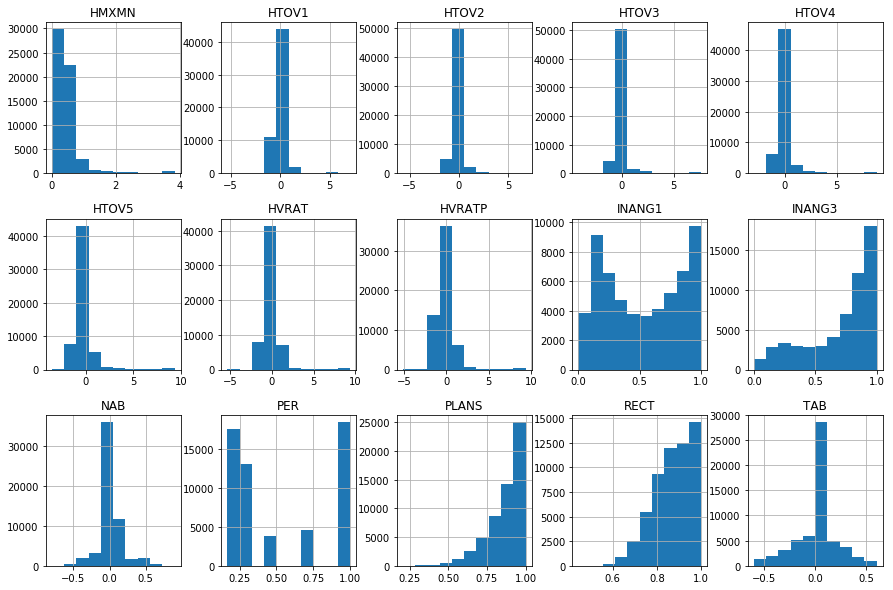

In [187]:
train.hist(figsize=(15,10), column=x_indices, layout=(3,5))

## Density plot

### Train

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d5190b588>,
      dtype=object)

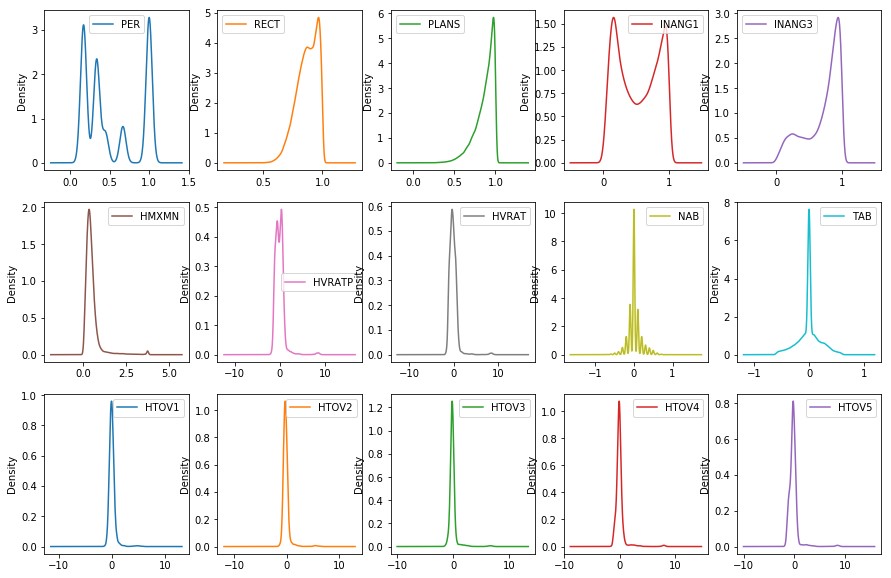

In [188]:
train[x_indices].plot(kind='density', figsize=(15,10), subplots=True, layout=(3,5), sharex=False)

### Correlation

[Text(0,0,'PER'),
 Text(0,0,'RECT'),
 Text(0,0,'PLANS'),
 Text(0,0,'INANG1'),
 Text(0,0,'INANG3'),
 Text(0,0,'HMXMN'),
 Text(0,0,'HVRATP'),
 Text(0,0,'HVRAT'),
 Text(0,0,'NAB'),
 Text(0,0,'TAB'),
 Text(0,0,'HTOV1'),
 Text(0,0,'HTOV2'),
 Text(0,0,'HTOV3'),
 Text(0,0,'HTOV4'),
 Text(0,0,'HTOV5')]

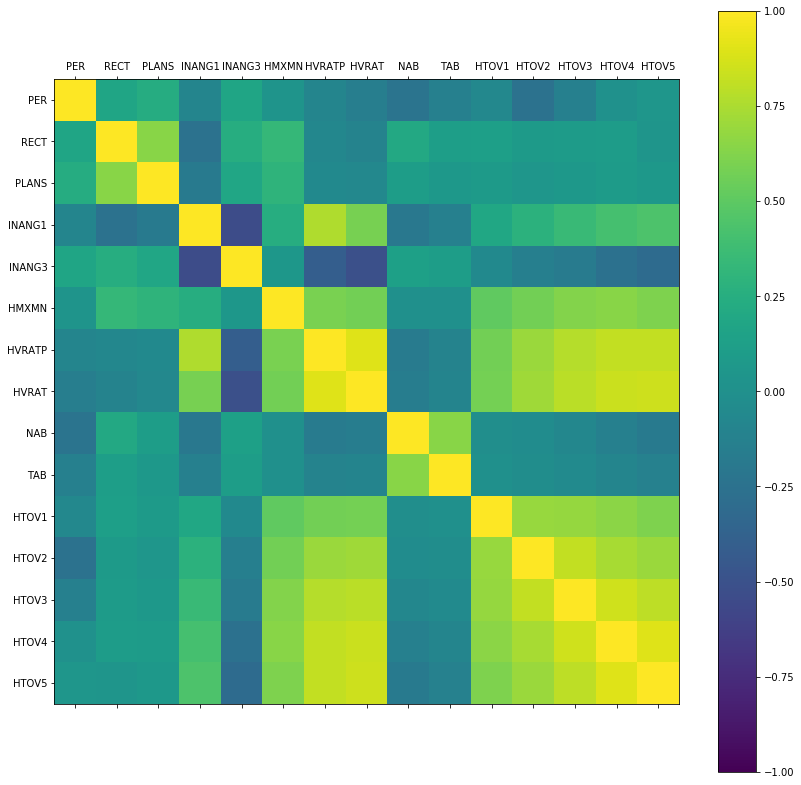

In [189]:
correlations = train[x_indices].corr()
# plot correlation matrix
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,15,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(x_indices)
ax.set_yticklabels(x_indices)

### Scatter plot

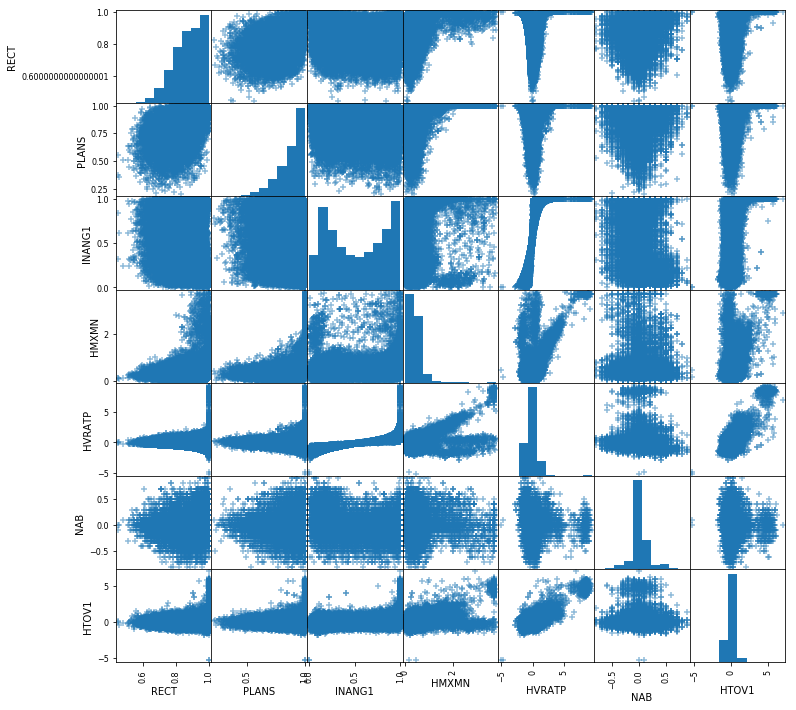

In [190]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
scatter_matrix(train[['RECT', 'PLANS', 'INANG1', 'HMXMN', 'HVRATP', 'NAB', 'HTOV1']], figsize=(12,12), marker='+')
plt.show()

In [ ]:
?scatter_matrix

### Extract features and class labels

In [172]:
train_X = train[x_indices].values.astype(float)
train_Y = train[y_indices]

test_X = test[x_indices].values.astype(float)
test_Y = test[y_indices]

train_Y_ = numpy.array(numpy.where(train_Y == 'N', 1, 0), dtype=float)
test_Y_ = numpy.array(numpy.where(test_Y == 'N', 1, 0), dtype=float)

#convert to categorical
train_Y = keras.utils.to_categorical(train_Y_)
test_Y = keras.utils.to_categorical(test_Y_)

test_metadata = test[metadata]

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
print(test_metadata.shape)

(57347, 15) (57347, 2) (6373, 15) (6373, 2)
(6373, 9)


### verification, that if node1 < 0.5 => N (nodes start at 1: node1, node2)

In [195]:
train[y_indices+x_indices][:10]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,N,1.000000,0.962667,0.940395,0.265264,0.533510,0.460426,-0.858886,-0.269497,0.0,0.000000,0.170525,-0.444539,-0.592390,-0.254998,-0.167790
1,N,1.000000,0.916554,0.865863,0.772909,0.616768,0.652766,0.389634,0.389634,0.0,0.000000,-0.247779,-0.492589,-0.386221,0.196163,-0.385813
2,tele,0.333333,0.986773,0.981036,0.275091,0.941314,1.145288,-0.923942,-0.668548,0.5,0.294900,0.119230,-1.484874,-1.308913,-0.807381,-1.137817
3,N,1.000000,0.924930,0.943803,0.246472,0.921838,0.284778,-0.799475,-0.799475,0.0,0.000000,-0.344711,-0.673466,-0.351143,0.023970,-0.350049
4,N,0.333333,0.840432,0.781789,0.816528,0.200865,0.027492,0.444289,0.444289,-0.1,-0.120500,-0.008641,-0.797753,-0.002276,-0.312879,0.552390
5,N,0.166667,0.870543,0.815244,0.190297,0.840530,0.103159,-0.741027,-0.592056,0.1,0.275750,-0.307247,-0.327919,-0.093805,-0.025411,-0.729376
6,N,0.166667,0.754946,0.661478,0.834655,0.931460,0.351719,0.618943,-0.211508,-0.1,-0.445750,-0.261388,0.367064,-0.343319,0.224481,-0.663684
7,N,0.444444,0.917415,1.000000,0.510038,0.999884,3.166060,-0.281404,-0.632342,-0.3,-0.286833,-0.972464,-0.415531,-0.717251,-0.849889,0.035719
8,tele,0.444444,0.930771,0.843498,0.892538,0.479210,0.819780,0.654585,0.248837,-0.1,-0.102896,0.352605,1.057624,-0.059344,0.154816,0.035818
9,N,1.000000,0.961272,0.989319,0.215751,0.856375,0.422835,-0.991402,-1.089764,0.0,0.000000,0.225621,-0.417045,-0.473448,0.172684,-0.425983


In [196]:
train_Y[:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

#### Ground truth for all 4 classes

In [47]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['N', 'regP', 'regS', 'tele'])
test_Y_GT = le.transform(test[y_indices])
train_Y_GT = le.transform(train[y_indices])
test_Y_GT[:200]

/dvlscratch/SHI/users/hofman/ML/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 0, 0, 0, 3, 3, 3, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0,
       3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       3, 0, 2, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 0, 3, 0, 3, 3,
       0, 3])

# Neural network N vs TPS

#### This section is based on retime=0 data with 4 times more noise than associated phases

In [79]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

In [80]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model = Sequential()
model.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
adam = Adam(lr=0.0001) #, clipnorm, clipvalue=0.5)

model.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [82]:
hist_keys = ('acc', 'val_acc', 'loss', 'val_loss')

In [46]:
history = {k : [] for k in hist_keys}

In [ ]:
class_weight = {0 : 1.,  # PST 1 to loss
                1: 0.05}  # noise = 0.1 weights to loss

h = model.fit(train_X[:], train_Y[:], 
          epochs=500, 
          batch_size=256, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=(test_X, test_Y),
          class_weight=class_weight)

history = {k : history[k] + h.history[k] for k in hist_keys}

In [84]:
train_Y[train_Y==0].shape, train_Y[train_Y==1].shape
test_Y[test_Y[:,0]==1].shape, test_Y[test_Y[:,1]==1].shape

((1275, 2), (5098, 2))

In [85]:
test_Y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

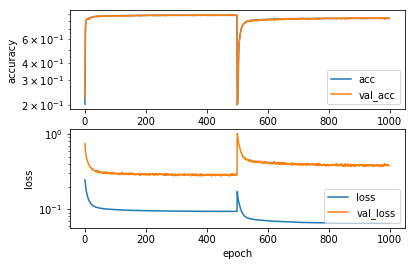

In [86]:
plot(history, semilog=True)

In [125]:
# calculate predicted values
Y_pred_ = model.predict(test_X)
# predictions are outputted as floats from [0,1]
print(Y_pred_[:10])

[[0.14181213 0.85818785]
 [0.53706205 0.46293786]
 [0.09683329 0.9031667 ]
 [0.7138769  0.28612304]
 [0.25404322 0.7459568 ]
 [0.28626403 0.7137359 ]
 [0.11023867 0.88976127]
 [0.8985982  0.10140175]
 [0.78499866 0.2150013 ]
 [0.4346412  0.5653587 ]]


In [126]:
Y_pred_.sum(axis=1).min(), Y_pred_.sum(axis=1).max()

(0.99999976, 1.0000002)

In [127]:
Y_pred = numpy.argmax(Y_pred_, axis=1)
Y_pred[:20]

array([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1])

In [128]:
from sklearn.metrics import confusion_matrix

# we must translate it to 0, 1 based on thresholding at 0.5
# where < 0.5 set to 0, to 1 otherwise
#Y_pred = numpy.where(Y_pred < 0.5, 0, 1)

# calculate confusion matrix
conf_mat = confusion_matrix(test_Y_, Y_pred)
print(conf_mat)

[[1226   49]
 [1335 3763]]


In [129]:
## confusion matrix on Train?
Y_pred = numpy.argmax(model.predict(train_X), axis=1)
conf_mat = confusion_matrix(train_Y_, Y_pred)
print(conf_mat)

[[11073   396]
 [11863 34015]]


In [112]:
#eval on test data
model.evaluate(test_X, test_Y)

6373/6373 [==============================] - 0s 8us/step


[0.4299877163741159, 0.8215910873999687]

In [113]:
model.evaluate(train_X, train_Y)

57347/57347 [==============================] - 0s 7us/step


[0.42140696735790095, 0.8254660226351789]

In [130]:
#save model and weights, NTC = contextual features correct, Rt => retime <= t seconds
model.save('URZ_R0_NTC3_NTPS.h5')

# Neural network TP vs S 

#### This section is based on retime=2 data

* we need a new dataset for this

## Dataset for TP vs S

In [217]:
print(TPS_train.shape, TPS_test.shape)

(31656, 25) (3518, 25)


In [193]:
train_X_TPS = TPS_train[x_indices].values.astype(float)
train_Y_TPS = TPS_train[y_indices]

test_X_TPS = TPS_test[x_indices].values.astype(float)
test_Y_TPS = TPS_test[y_indices]

#regS = 1, T/regP = 0
train_Y_TPS_ = numpy.array(numpy.where(train_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)
test_Y_TPS_ = numpy.array(numpy.where(test_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)

#convert to categorical
train_Y_TPS = keras.utils.to_categorical(train_Y_TPS_)
test_Y_TPS = keras.utils.to_categorical(test_Y_TPS_)

print(train_X_TPS.shape, train_Y_TPS.shape, test_X_TPS.shape, test_Y_TPS.shape)

(11469, 15) (11469, 2) (1275, 15) (1275, 2)


### test if node3 < 0.5 => S

In [191]:
TPS_train[y_indices+x_indices][:10]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,tele,0.333333,0.728961,0.580715,0.260514,0.767706,0.358136,-0.454527,-0.261908,0.2,0.428750,0.219710,0.070092,-0.347456,-0.422958,-0.712976
1,tele,0.166667,0.943720,0.891063,0.042241,0.976690,0.178970,-1.232000,-1.073246,0.2,0.319750,0.054309,-0.002823,-0.280774,-0.884879,-1.016777
2,regP,0.333333,0.973174,0.935052,0.282989,0.813268,0.753960,-0.857183,-0.686924,0.5,0.333650,-0.476494,-0.609796,-0.881545,-0.558994,-0.973896
3,tele,0.666667,0.922029,0.991369,0.266012,0.779160,0.083398,-0.738234,-0.721603,0.2,0.176875,0.030162,-0.187222,-0.706779,-0.324758,-0.163270
4,regP,0.166667,0.961498,0.918782,0.135828,0.995858,0.681324,-1.206293,-1.068854,0.2,0.212625,-0.171501,-0.052673,-0.657084,0.208199,-0.910123
5,regS,0.166667,0.892195,0.905780,0.902946,0.166483,0.490607,0.721162,0.875421,-0.1,-0.119375,-0.660888,0.286008,0.222194,0.637261,-0.084582
6,tele,0.333333,0.860824,0.878762,0.736711,0.925675,0.622801,0.108640,-0.634466,0.0,0.000000,0.010373,0.099694,-0.244729,-0.158597,-1.667443
7,tele,0.333333,0.835412,0.932712,0.769570,0.295837,0.288525,0.508481,0.516492,0.1,-0.224000,0.042433,0.423999,0.291426,0.799837,0.651211
8,tele,0.666667,0.946586,0.905236,0.210366,0.841687,0.406185,-0.942286,-0.804910,-0.1,-0.144250,1.092449,-0.068427,-0.289508,-0.695181,-1.063210
9,regP,0.166667,0.987946,0.979181,0.131464,0.891723,0.363762,-1.465303,-1.366333,0.5,0.324650,0.108663,-0.105177,-0.162137,-0.067765,-1.155592


In [194]:
train_Y_TPS[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

### Manually added datasets for testing

In [164]:
#those manually added
nsm = df_S_all[df_S_all['SOURCE'] == 'M'].shape[0]
npm = df_P_all[df_P_all['SOURCE'] == 'M'].shape[0]
ntm = df_T_all[df_T_all['SOURCE'] == 'M'].shape[0]
nnm = df_N_all[df_N_all['SOURCE'] == 'M'].shape[0]

#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
man_samp_count = min(nsm, npm, ntm)

#sample TPS dataset, random_state is a seed
mssS = df_S_all[df_S_all['SOURCE'] == 'M'].sample(man_samp_count, random_state=11)
mssP = df_P_all[df_P_all['SOURCE'] == 'M'].sample(man_samp_count)
mssT = df_T_all[df_T_all['SOURCE'] == 'M'].sample(man_samp_count)
MTPS_data = pd.concat([mssS, mssP, mssT])


#normalize

MTPS_data_norm = MTPS_data.copy(deep=True)
MTPS_data_norm['INANG1'] /= 90.
MTPS_data_norm['INANG3'] /= 90.
MTPS_data_norm['HMXMN'] = numpy.log10(MTPS_data['HMXMN'])
MTPS_data_norm['HVRATP'] = numpy.log10(MTPS_data['HVRATP'])
MTPS_data_norm['HVRAT'] = numpy.log10(MTPS_data['HVRAT'])
MTPS_data_norm['HTOV1'] = numpy.log10(MTPS_data['HTOV1'])
MTPS_data_norm['HTOV2'] = numpy.log10(MTPS_data['HTOV2'])
MTPS_data_norm['HTOV3'] = numpy.log10(MTPS_data['HTOV3'])
MTPS_data_norm['HTOV4'] = numpy.log10(MTPS_data['HTOV4'])
MTPS_data_norm['HTOV5'] = numpy.log10(MTPS_data['HTOV5'])

#manually added noise makes nos sense - we do not sanmple N

#lets shuffle dataset
MTPS_data_norm = MTPS_data_norm.sample(frac=1).reset_index(drop=True)

manual_X = MTPS_data_norm[x_indices].values.astype(float)
#regS = 0, T/regP = 1
manual_Y_TPS_ = numpy.array(numpy.where(MTPS_data_norm[y_indices] == 'regS', 1, 0), dtype=float)
manual_Y_TPS = keras.utils.to_categorical(manual_Y_TPS_)

print(manual_X.shape, manual_Y_TPS.shape, manual_Y_TPS_.shape)

(6006, 15) (6006, 2) (6006, 1)


#### Manual dataset ground truth

In [202]:
manual_Y_GT = le.transform(MTPS_data_norm[y_indices])
manual_Y_GT[:10]

/dvlscratch/SHI/users/hofman/ML/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 2, 3, 1, 3, 2, 3, 1, 1, 2])

### Neural network

In [221]:
history_TPS = {k : [] for k in hist_keys}

In [222]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TPS = Sequential()
model_TPS.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TPS.add(Dense(2, activation='sigmoid'))

model_TPS.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [223]:
model_TPS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 6)                 96        
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [224]:
#class weights
S_weight = nsa/(nsa+npa+nta)
PT_weight = (npa+nta)/(nsa+npa+nta)
print(S_weight, PT_weight)
print(nsa/(npa+nta))

0.16836299539432537 0.8316370046056747
0.20244769588404213


In [ ]:
class_weight = {0 : 0.2,  # PT is five times more abundant
                1: 1}  # S = 1 weights to loss
h = model_TPS.fit(train_X_TPS[:], train_Y_TPS[:], 
          epochs=500, 
          batch_size=256, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([test_X_TPS, test_Y_TPS]),
          class_weight=class_weight)

history_TPS = {k : history_TPS[k] + h.history[k] for k in hist_keys}

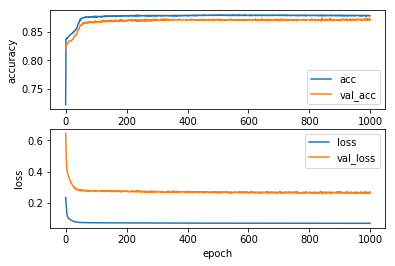

In [229]:
plot(history_TPS)

In [230]:
#NC = nodes correct
model_TPS.save('URZ_R2_NTC_TPS.h5')

In [231]:
model_TPS.evaluate(test_X_TPS, test_Y_TPS)

3518/3518 [==============================] - 0s 7us/step


[0.2628767770281429, 0.8730812962587887]

#### Test data confusion matrix

In [232]:
Y_pred = numpy.reshape(numpy.argmax(model_TPS.predict(test_X_TPS), axis=1), (test_X_TPS.shape[0],1))

# calculate confusion matrix
C = confusion_matrix(test_Y_TPS_, Y_pred)
print(C)

[[2473  436]
 [  11  598]]


In [233]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 87.29%


#### Just for curiosity -  Manual associations confusion matrix

In [234]:
Y_pred_man = numpy.argmax(model_TPS.predict(manual_X), axis=1)

# calculate confusion matrix
C = confusion_matrix(manual_Y_TPS_, Y_pred_man)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[2835 1169]
 [  99 1903]]
Accuracy: 78.89%


# Neural network T vs regP 

#### This section is based on retime=2 data

* we need a new dataset for this

### Dataset for T vs regP

In [198]:
#exclude regS
TP_train = TPS_train[TPS_train['CLASS_PHASE'] != 'regS']
TP_test  = TPS_test [TPS_test ['CLASS_PHASE'] != 'regS']

In [199]:
train_X_TP = TP_train[x_indices].values.astype(float)
train_Y_TP = TP_train[y_indices]

test_X_TP = TP_test[x_indices].values.astype(float)
test_Y_TP = TP_test[y_indices]

#regS = 0, T/regP = 1
train_Y_TP_ = numpy.array(numpy.where(train_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)
test_Y_TP_ = numpy.array(numpy.where(test_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)

#convert to categorical
train_Y_TP = keras.utils.to_categorical(train_Y_TP_)
test_Y_TP = keras.utils.to_categorical(test_Y_TP_)

print(train_X_TP.shape, train_Y_TP.shape, test_X_TP.shape, test_Y_TP.shape)

(9812, 15) (9812, 2) (1064, 15) (1064, 2)


### test if node5 < 0.5 => P

In [200]:
TP_train[y_indices + x_indices][:10]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,tele,0.333333,0.728961,0.580715,0.260514,0.767706,0.358136,-0.454527,-0.261908,0.2,0.428750,0.219710,0.070092,-0.347456,-0.422958,-0.712976
1,tele,0.166667,0.943720,0.891063,0.042241,0.976690,0.178970,-1.232000,-1.073246,0.2,0.319750,0.054309,-0.002823,-0.280774,-0.884879,-1.016777
2,regP,0.333333,0.973174,0.935052,0.282989,0.813268,0.753960,-0.857183,-0.686924,0.5,0.333650,-0.476494,-0.609796,-0.881545,-0.558994,-0.973896
3,tele,0.666667,0.922029,0.991369,0.266012,0.779160,0.083398,-0.738234,-0.721603,0.2,0.176875,0.030162,-0.187222,-0.706779,-0.324758,-0.163270
4,regP,0.166667,0.961498,0.918782,0.135828,0.995858,0.681324,-1.206293,-1.068854,0.2,0.212625,-0.171501,-0.052673,-0.657084,0.208199,-0.910123
6,tele,0.333333,0.860824,0.878762,0.736711,0.925675,0.622801,0.108640,-0.634466,0.0,0.000000,0.010373,0.099694,-0.244729,-0.158597,-1.667443
7,tele,0.333333,0.835412,0.932712,0.769570,0.295837,0.288525,0.508481,0.516492,0.1,-0.224000,0.042433,0.423999,0.291426,0.799837,0.651211
8,tele,0.666667,0.946586,0.905236,0.210366,0.841687,0.406185,-0.942286,-0.804910,-0.1,-0.144250,1.092449,-0.068427,-0.289508,-0.695181,-1.063210
9,regP,0.166667,0.987946,0.979181,0.131464,0.891723,0.363762,-1.465303,-1.366333,0.5,0.324650,0.108663,-0.105177,-0.162137,-0.067765,-1.155592
10,regP,0.166667,0.993858,1.000000,0.117692,0.999980,2.259241,-1.626766,-1.626766,0.6,0.290583,-0.126911,-0.548354,-0.661174,-0.980486,-1.593060


In [201]:
train_Y_TP[:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

### Neural network

In [239]:
history_TP = {k : [] for k in hist_keys}

In [240]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TP = Sequential()
model_TP.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TP.add(Dense(2, activation='sigmoid'))

model_TP.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [242]:
npa/nta

0.3336372754627519

In [ ]:
class_weight = {0 : 0.334,  # T is 3 times more abundant
                1: 1}  # P
h = model_TP.fit(train_X_TP[:], train_Y_TP[:], 
          epochs=500, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([test_X_TP, test_Y_TP]))

history_TP = {k : history_TP[k] + h.history[k] for k in hist_keys}

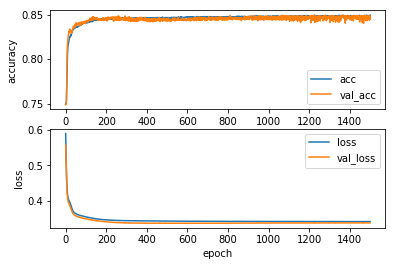

In [256]:
plot(history_TP)

In [255]:
#NC = nodes correct
model_TP.save('URZ_R2_NTC_TP.h5')

In [253]:
model_TP.evaluate(test_X_TP, test_Y_TP)

2909/2909 [==============================] - 0s 7us/step


[0.33729554605713497, 0.844963905203994]

#### Test data confusion matrix

In [254]:
Y_pred = numpy.reshape(numpy.argmax(model_TP.predict(test_X_TP), axis=1), (test_X_TP.shape[0],1))

# calculate confusion matrix
conf_mat = confusion_matrix(test_Y_TP_, Y_pred)
print(conf_mat)

[[1974  204]
 [ 247  484]]


In [ ]:
[[624 102]
 [ 87 251]]


# Cascade of all three models

In [39]:
from keras.models import load_model

In [68]:
model_NTPS = load_model('URZ_R0_NTC3_NTPS.h5')
model_STP = load_model('URZ_R2_NTC_TPS.h5')
model_PT = load_model('URZ_R2_NTC_TP.h5')

In [69]:
def predict_iwt(X, stage=0):
    """
    predicts initial wave type for given featrue vectors
    Class encoding generated by sklearn Label Encoder
    0 - noise
    2 - regS 
    1 - regP
    3 - T
    """
    Y = numpy.arange(X.shape[0])
    
    N_indices = None
    S_indices = None 
    
    if stage >= 1:
        N_indices = [False] * X.shape[0]
        X_PTS = X
        Y_NPTS = numpy.zeros(X.shape[0])
    if stage >= 2:
        S_indices =  [False] * X.shape[0]  # numpy.array([])
        X_PT = X
        Y_PTS = numpy.zeros(X.shape[0])
        
    
    """
    N vs regS, regP, T
    """
    if N_indices is None:
        #predict N vs T,regP,regS
        Y_NPTS = numpy.argmax(model_NTPS.predict(X), axis=1)
        #set which are noise
        N_indices = Y[Y_NPTS == 1]  #  = 0
        #get candidates for TPS
        X_PTS = X[Y_NPTS < 1]
    else:
        print('Skipping N, classifying TPS only')

    """
    regS vs regP, T
    """
    if S_indices is None:    
        #predict regS vs T,regP
        Y_PTS = numpy.argmax(model_STP.predict(X_PTS), axis=1)
        #set which are regS
        S_indices = Y[Y_NPTS < 1][Y_PTS == 1]  # = 2
        #get candidates for regP,T
        X_PT = X_PTS[Y_PTS < 1]
    else:
        print('Skipping N, regS, classifying TP only')

    """
    regP vs T
    """
    #predict regP vs T
    Y_PT = numpy.argmax(model_PT.predict(X_PT), axis=1)
    #set which are regP
    P_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT == 1]  # = 1    
    #set which are T
    T_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT < 1]   # = 3
    #get those which are T
    X_T = X_PT[Y_PT < 1]
    
    Y[N_indices] = 0 # N
    Y[S_indices] = 2 # regS
    Y[P_indices] = 1 # regP 
    Y[T_indices] = 3 # tele
    
    return Y
    

In [173]:
Y = predict_iwt(test_X)

### Overall confusion matrix for test data (with retime=0)

In [174]:
test_X.shape, Y.shape, test_Y_GT.shape

((6373, 15), (6373,), (6373,))

In [175]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(Y, test_Y_GT)
print(C)

[[3763    2   26   21]
 [ 155  238    0   89]
 [ 776    0  182  124]
 [ 404   98    3  492]]


In [176]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 73.36%


#### Let's produce result data frame from metadata and results (with retime=0)

In [177]:
class_dict = {0:'N', 1:'regP', 2:'regS', 3:'tele'}
Y_pred_cat = [class_dict[yi] for yi in Y]
print(len(Y_pred_cat))

6373


In [178]:
test_metadata = test[metadata]

In [179]:
#let's add new column to the pandas dataframe
#test_metadata['CLASS_IPHASE_NEW'] = Y_pred_cat  # deprecated - gives warning
test_metadata.assign(CLASS_IPHASE_NEW = pd.Series(Y_pred_cat, index=test_metadata.index)).to_csv('test_set_prediction.txt', na_rep='null',columns=metadata+["CLASS_IPHASE_NEW"]) 

In [180]:
### some experiment section..

In [181]:
test_pred_Y = predict_iwt(test_X)

In [182]:
test_X.shape
train_X.shape

(57347, 15)

In [183]:
test_iphase_Y = le.transform(test['CLASS_IPHASE'])
test_truth_Y = le.transform(test['CLASS_PHASE'])

In [184]:
test_truth_Y.min(), test_truth_Y.max()

(0, 3)

In [185]:
test_iphase_Y.min(), test_iphase_Y.max()

(0, 3)

In [186]:
#print('IPHASE:')
C = confusion_matrix(test_pred_Y, test_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[3763    2   26   21]
 [ 155  238    0   89]
 [ 776    0  182  124]
 [ 404   98    3  492]]
Accuracy: 73.36%


### Test data just regS, regP, T - not to be confused with overall statistics on all arrivals in our DB

In [84]:
test_TPS = test[test['CLASS_PHASE'] != 'N']
test_TPS_X = test_TPS[x_indices]
test_TPS_pred_Y = predict_iwt(test_TPS_X)
test_TPS_truth_Y = le.transform(test_TPS['CLASS_PHASE'])
test_TPS_iphase_Y = le.transform(test_TPS['CLASS_IPHASE'])

In [85]:
test_TPS_iphase_Y.min(), test_TPS_iphase_Y.max()

(0, 3)

In [86]:
print('IPHASE:')
C = confusion_matrix(test_TPS_iphase_Y, test_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

IPHASE:
[[  0  25  65  76]
 [  0 290  18 211]
 [  0   1 124  99]
 [  0  22   4 340]]
Accuracy: 59.14%


In [87]:
print('NEW PREDICTION')
C = confusion_matrix(test_TPS_pred_Y, test_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

NEW PREDICTION
[[  0   2  26  21]
 [  0 238   0  89]
 [  0   0 182 124]
 [  0  98   3 492]]
Accuracy: 71.53%


* in the test data, the current iwt characterized 166 as NOISE (first row of confusion matrix)
* our new iwt would characterize 49 as NOISE
* after re-training, accuracy on the test set rose from 59.14% to 71.53% for regS, regP and T phases

# Prediction on 2017 - Jan to May TEST

### Load data

Time span January to May in ST_E_TABLES: 1483227663.17 and 1496272787.045

In [88]:
query = """select * from ml_features where sta='URZ' and class_phase='regS' and time between 1483227663.17 and 1496272787.045"""
df_S_2017 = pd.read_sql(query, con=connection)
query = """select * from ml_features where sta='URZ' and class_phase='regP' and time between 1483227663.17 and 1496272787.045"""
df_P_2017 = pd.read_sql(query, con=connection)
query = """select * from ml_features where sta='URZ' and class_phase='tele' and time between 1483227663.17 and 1496272787.045"""
df_T_2017 = pd.read_sql(query, con=connection)
query = """select * from ml_features where sta='URZ' and class_phase='N' and time between 1483227663.17 and 1496272787.045"""
df_N_2017 = pd.read_sql(query, con=connection)
print(df_S_2017.shape, df_P_2017.shape, df_T_2017.shape, df_N_2017.shape)

(272, 25) (309, 25) (1001, 25) (16417, 25)


In [89]:
data_2017 = pd.concat([df_P_2017, df_S_2017, df_T_2017])
data_2017_wN = pd.concat([df_P_2017, df_S_2017, df_T_2017, df_N_2017])

In [90]:
data_2017_X = data_2017[x_indices]

data_2017_norm = data_2017[x_indices].copy(deep=True)
data_2017_norm['INANG1'] /= 90.
data_2017_norm['INANG3'] /= 90.
data_2017_norm['HMXMN'] = numpy.log10(data_2017_X['HMXMN'])
data_2017_norm['HVRATP'] = numpy.log10(data_2017_X['HVRATP'])
data_2017_norm['HVRAT'] = numpy.log10(data_2017_X['HVRAT'])
data_2017_norm['HTOV1'] = numpy.log10(data_2017_X['HTOV1'])
data_2017_norm['HTOV2'] = numpy.log10(data_2017_X['HTOV2'])
data_2017_norm['HTOV3'] = numpy.log10(data_2017_X['HTOV3'])
data_2017_norm['HTOV4'] = numpy.log10(data_2017_X['HTOV4'])
data_2017_norm['HTOV5'] = numpy.log10(data_2017_X['HTOV5'])

data_2017_X_wN = data_2017_wN[x_indices]

data_2017_norm_wN = data_2017_wN[x_indices].copy(deep=True)
data_2017_norm_wN['INANG1'] /= 90.
data_2017_norm_wN['INANG3'] /= 90.
data_2017_norm_wN['HMXMN'] = numpy.log10(data_2017_X_wN['HMXMN'])
data_2017_norm_wN['HVRATP'] = numpy.log10(data_2017_X_wN['HVRATP'])
data_2017_norm_wN['HVRAT'] = numpy.log10(data_2017_X_wN['HVRAT'])
data_2017_norm_wN['HTOV1'] = numpy.log10(data_2017_X_wN['HTOV1'])
data_2017_norm_wN['HTOV2'] = numpy.log10(data_2017_X_wN['HTOV2'])
data_2017_norm_wN['HTOV3'] = numpy.log10(data_2017_X_wN['HTOV3'])
data_2017_norm_wN['HTOV4'] = numpy.log10(data_2017_X_wN['HTOV4'])
data_2017_norm_wN['HTOV5'] = numpy.log10(data_2017_X_wN['HTOV5'])

In [91]:
data_2017_Y = numpy.zeros(data_2017.shape[0])
data_2017_Y[:df_P_2017.shape[0]] = 1
data_2017_Y[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 2
data_2017_Y[df_P_2017.shape[0]+df_S_2017.shape[0]:] = 3

data_2017_Y_wN = numpy.zeros(data_2017_wN.shape[0])
data_2017_Y_wN[:df_P_2017.shape[0]] = 1
data_2017_Y_wN[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 2
data_2017_Y_wN[df_P_2017.shape[0]+df_S_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]+df_T_2017.shape[0]] = 3

### Predict and evaluate

In [92]:
model_NTPS = load_model('URZ_R0_NTC3_NTPS.h5')
model_STP = load_model('URZ_R2_NTC_TPS.h5')
model_PT = load_model('URZ_R2_NTC_TP.h5')

In [93]:
data_2017_pred = predict_iwt(data_2017_norm)
data_2017_pred_wN = predict_iwt(data_2017_norm_wN)

In [95]:
C = confusion_matrix(data_2017_pred, data_2017_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (C[0,:].sum()/C.sum()*100))

[[  0  12  48  43]
 [  0 195   2  68]
 [  0   2 220 221]
 [  0 100   2 669]]
Accuracy: 68.52%
N phase rate: 6.51%


In [96]:
C = confusion_matrix(data_2017_pred_wN, data_2017_Y_wN)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[9740   12   48   43]
 [ 991  195    2   68]
 [2477    2  220  221]
 [3209  100    2  669]]
Accuracy: 60.14%


In [97]:
 data_2017_Y_wN.shape

(17999,)

In [98]:
print('N', data_2017_Y_wN[data_2017_Y_wN==0].shape)
print('P', data_2017_Y_wN[data_2017_Y_wN==1].shape)
print('S', data_2017_Y_wN[data_2017_Y_wN==2].shape)
print('T', data_2017_Y_wN[data_2017_Y_wN==3].shape)

N (16417,)
P (309,)
S (272,)
T (1001,)


## Overall results on train data just to see if it works...

In [99]:
Y = predict_iwt(train_X)
C = confusion_matrix(Y, train_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[34015    49   168   179]
 [ 1513  2067     4   827]
 [ 6602    20  1462  1212]
 [ 3748   904    23  4554]]
Accuracy: 73.41%


### Overall confusion matrix for all manual associations (no Noise)

In [ ]:
C = confusion_matrix(predict_iwt(manual_X, stage=1), manual_Y_GT)
print(C)

In [ ]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

## Let's try all noise samples we have

### Here we have only Noise phases automatically classified as noise by the current StaPro, not all NOISE after anlyst review!

In [134]:
# let's get all noise phases not used for training
N_data_diff = pd.concat([df_N_all, N_data]).loc[
    df_N_all.index.symmetric_difference(N_data.index)
]

In [135]:
print(N_data_diff.shape, df_N_all.shape, N_data.shape)
print(N_data_diff.shape[0], 'should equal', df_N_all.shape[0]-N_data.shape[0])

(232427, 25) (283403, 25) (50976, 25)
232427 should equal 232427


In [136]:
N_data_norm = N_data_diff[x_indices].copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data_diff['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data_diff['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data_diff['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data_diff['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data_diff['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data_diff['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data_diff['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data_diff['HTOV5'])

In [137]:
N_data_norm.shape

(232427, 15)

In [138]:
N_X = N_data_norm[x_indices].values.astype(float)
N_Y = numpy.zeros(N_X.shape[0])

print(N_X.shape, N_Y.shape)

(232427, 15) (232427,)


In [139]:
Y = predict_iwt(N_X)
C = confusion_matrix(Y, N_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[170042      0      0      0]
 [  8336      0      0      0]
 [ 34329      0      0      0]
 [ 19720      0      0      0]]
Accuracy: 73.16%


* From all avaibale noise phases which were not used for training we are able to correctly identify 73.16%

### 2017 noise including all after analyst review up to November (1512000000 2017334  2017/11/30 00:00:00 Nov Thu)

In [140]:
query = """select * from ml_features where sta='URZ' and class_phase='N' and time between 1483228800 and 1512000000"""
N2017 = pd.read_sql(query, con=connection)

In [141]:
query = """select max(time) from ml_features where sta='URZ' and class_phase='N'"""
%sql $query

0 rows affected.


MAX(TIME)
1516618436.069


In [142]:
N2017.shape

(32502, 25)

In [143]:
N2017_norm = N2017[x_indices].copy(deep=True)
N2017_norm['INANG1'] /= 90.
N2017_norm['INANG3'] /= 90.
N2017_norm['HMXMN'] = numpy.log10(N2017['HMXMN'])
N2017_norm['HVRATP'] = numpy.log10(N2017['HVRATP'])
N2017_norm['HVRAT'] = numpy.log10(N2017['HVRAT'])
N2017_norm['HTOV1'] = numpy.log10(N2017['HTOV1'])
N2017_norm['HTOV2'] = numpy.log10(N2017['HTOV2'])
N2017_norm['HTOV3'] = numpy.log10(N2017['HTOV3'])
N2017_norm['HTOV4'] = numpy.log10(N2017['HTOV4'])
N2017_norm['HTOV5'] = numpy.log10(N2017['HTOV5'])

In [144]:
N2017_X = N2017_norm[x_indices].values.astype(float)
N2017_Y = numpy.zeros(N2017_X.shape[0])

print(N2017_X.shape, N2017_Y.shape)

(32502, 15) (32502,)


In [145]:
Y2017 = predict_iwt(N2017_X)
C = confusion_matrix(Y2017, N2017_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[18772     0     0     0]
 [ 1912     0     0     0]
 [ 5450     0     0     0]
 [ 6368     0     0     0]]
Accuracy: 57.76%


# Let's analyze weights and generate a new NN weight file!

In [120]:
model_NTPS = load_model('URZ_R0_NTC3_NTPS.h5')
model_STP = load_model('URZ_R2_NTC_TPS.h5')
model_PT = load_model('URZ_R2_NTC_TP.h5')

In [121]:
weights_NTPS = model_NTPS.get_weights()
weights_STP = model_STP.get_weights()
weights_PT = model_PT.get_weights()

In [122]:
model_NTPS.get_config()

[{'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'batch_input_shape': (None, 15),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dtype': 'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'dense_5',
   'trainable': True,
   'units': 6,
   'use_bias': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kern

In [123]:
for w in weights_NTPS:
    print(w.shape)

(15, 6)
(6,)
(6, 2)
(2,)


In [124]:
for w in weights_STP:
    print(w.shape)
    print(w)

(15, 6)
[[-1.1831073  -1.5795983   0.08570425 -2.46308    -3.0063252  -2.1625435 ]
 [-1.1732373   0.06993501  1.4042137   1.3881706  -0.3441112  -1.0750246 ]
 [ 0.14994808  0.32872522  0.05546626  0.18878092  1.157792   -0.2768691 ]
 [ 0.05663528  0.3147132   0.00959466  2.1355798  -4.2633057  -0.4132832 ]
 [-0.8644269   2.011634   -0.04809634  0.0740239   4.1357946   2.5343328 ]
 [-0.5499675   0.36136883 -0.28820235  2.528721   -0.4997763  -0.73139554]
 [-0.705633    1.0334207   0.29009578  2.7618659   3.0881028   0.03543018]
 [ 1.8635393  -1.2751249  -0.12749566  0.84693193 -0.76131296 -7.0792017 ]
 [ 1.0278031   3.0246046   1.5429653   2.6906655   0.21865751  2.2183955 ]
 [ 3.9441736   1.229302    1.4561754  -1.7900883   1.7190124  -2.409372  ]
 [-1.5730523  -0.6080699   0.02729151 -1.1924918  -0.46942902  2.1699178 ]
 [ 0.839794   -0.06773943  0.10745802  3.55491     0.09008373 -2.5286543 ]
 [-3.449508   -0.761863    0.3588678   6.5542645   0.75307196 -1.7804823 ]
 [-8.648353    0.

In [125]:
for w in weights_PT:
    print(w.shape)
    print(w)

(15, 6)
[[ 8.6936526e-02  2.2378864e+00  2.7103310e+00 -1.2726447e+01
  -1.3073928e+00  1.3896835e+00]
 [-1.3828430e+00  2.1394024e+00 -6.5049952e-01  1.8813574e+00
  -1.4787859e+00 -1.7174659e+00]
 [ 1.3888541e+00  1.2071084e+00 -5.3984809e-01 -1.0174794e+00
   9.0631831e-01  2.2289765e+00]
 [-2.7169800e+00  5.9683390e+00  2.8046932e+00  1.0223473e+00
   1.9539613e+00 -1.4633327e+00]
 [-2.2161942e+00 -2.3420770e+00 -7.1652360e+00 -1.1222974e+00
   3.1263683e+00 -1.7715299e+00]
 [-1.5330231e+00 -5.0164709e+00 -6.1310959e+00 -1.6111578e-01
  -1.9448322e-01 -6.4581174e-01]
 [ 4.1021916e-01  2.3039050e-01 -1.7845137e+00 -1.0110233e+00
   6.4697164e-01 -2.2502820e-01]
 [-4.8377436e-01  1.0491540e+00  1.3176640e+00 -4.1055405e-01
   5.5584011e+00 -7.0908189e-01]
 [-9.0685320e-01  6.1351585e-01  4.9143295e+00  9.1947889e+00
  -1.6170847e+00 -1.0244020e+01]
 [-9.1329855e-01  5.3758416e+00 -7.1466142e-01  6.7540985e-01
   1.2937560e+00  5.8550680e-01]
 [-1.3951974e-01 -8.4212376e-04 -2.8250155

### Let's export it to a weigth file using a template

In [126]:
station_name = 'URZ'

In [127]:
# open template
with open(os.path.join('templates','%s.template' % station_name)) as f:
    template = f.read()
    #print(s)

In [128]:
import datetime
#put name to template
s = template.replace('{{station_name}}', station_name)
s = s.replace('{{date}}', datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))

In [129]:
weight_idents = ('TPSN', 'TPS', 'TP')
weights = (weights_NTPS, weights_STP, weights_PT)

In [130]:
#prepare weights
for ident, w in zip(weight_idents, weights):
    weights_layer_1 = ""
    for i in range(w[0].shape[0]):
        weights_layer_1 += ' '.join(list(map(lambda x: "%7.6f" % x, w[0][i,:])))
        if i < w[0].shape[0] - 1:
            weights_layer_1  += '\n'        
        
    bias_layer_1 = ' '.join(list(map(lambda x: "%7.6f" % x, w[1])))
    
    weights_layer_2 = ""
    for i in range(w[2].shape[0]):
        weights_layer_2 += ' '.join(list(map(lambda x: "%7.6f" % x, w[2][i,:])))
        if i < w[2].shape[0] - 1:
            weights_layer_2  += '\n'        
        
    bias_layer_2 = ' '.join(list(map(lambda x: "%7.6f" % x, w[3])))
    
    #put coefficients into template
    s = s.replace('{{%s_bias_layer_1}}' % ident, bias_layer_1) 
    s = s.replace('{{%s_weights_layer_1}}' % ident, weights_layer_1)
    s = s.replace('{{%s_bias_layer_2}}' % ident, bias_layer_2)
    s = s.replace('{{%s_weights_layer_2}}' % ident, weights_layer_2)
    
#print(bias_layer_1)
#print(weights_layer_1)
#print(bias_layer_2)
#print(weights_layer_2)

In [131]:
print(s)

*-- URZ.nn
*-- Comments ...
*-- Auxiliary 3C station URZ uses the new weights from retraining by RH
*-- Generated 2018/05/09 11:16:20
*-- {{training_summary}}
URZ
3
60.000000
  0.25   0.50   1.00   2.00   4.00
URZ TPS-N
628 3 16 7 2
-4.224370 1.470061 -1.551250 0.976768 -1.594422 -6.131534
-0.401208 -5.616818 1.474481 -1.243065 0.570315 0.294380
1.445552 2.662427 -2.143650 -1.612636 0.497038 1.599318
-0.680276 1.666650 -1.333593 1.575889 0.358971 -0.851674
0.319998 2.111832 0.573027 0.611792 -0.917011 -0.113104
0.203226 -1.137899 -0.572949 0.195110 -0.144673 1.042051
-0.835810 -0.183235 0.097406 -0.378389 0.558279 0.606634
-1.682955 -1.007920 0.242080 -0.208544 0.918337 0.209009
0.486017 1.438228 -0.409595 -0.102331 -1.074045 -0.723248
0.202505 1.475257 21.569639 3.712532 40.026489 3.119810
-0.094922 0.376140 -4.149570 0.617883 -6.514907 -1.140609
-0.582162 -0.597685 -0.521551 -0.091349 0.759911 0.410161
-0.645865 0.990940 -1.085148 -0.481359 0.083314 0.337670
-2.218628 -0.716295 -2.82

In [146]:
#save it
with open(os.path.join('nn_weights','%s_R0_NTC3.nn' % station_name), 'w+') as f:
    f.write(s)

### Experiment if the weight from C code gives the same results as here

arid=119744643 
 
Before normalization:
(1.000000,0.966347,0.977263,8.234518,88.750600,2.412571,0.044210,0.044210,0.300000,0.507750,1.166405,0.288975,0.655635,0.703711,0.243465) nab=0.300000 tab=0.507750

Normalized: 
(1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563) nab=0.300000 tab=0.507750

results of stages in C code (StaPro):
+++++ TPS-N: arid=119744643  node1=0.667373 node2=0.332627
+++++ TP-S: arid=119744643  node3=0.991951 node4=0.007760
+++++ T-P: arid=119744643  node5=0.862848 node6=0.137152


In [133]:
input = numpy.reshape(numpy.array([1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563]), (1,15))
print('TPS-N:', model_NTPS.predict(input))
print('TP-S :', model_STP.predict(input))
print('T-P  :', model_PT.predict(input))

TPS-N: [[0.66737413 0.3326257 ]]
TP-S : [[0.9919511  0.00776022]]
T-P  : [[0.86284804 0.13715191]]
